# **Facial Emotion Recognition Leveraging Deep Learning and the AffectNet Dataset**

---

## **International University of Rabat**

### **Project Overview**
This project focuses on the implementation and analysis of deep learning techniques for facial emotion recognition, leveraging the AffectNet dataset.  


### **Supervised By**
**Professor Zakroum Mehdi**

---

### **Objective**
Explore, implement, and fine-tune models to accurately detect emotions from facial images using advanced deep learning techniques.  

---



# Importing the necessary libraries

We selected these libraries for their robust support in data processing and model development. TensorFlow and Keras provide advanced tools for deep learning, including model creation and optimization. NumPy and pandas handle numerical and tabular data efficiently, while Matplotlib facilitates visualization. ImageDataGenerator and related utilities streamline image preprocessing, and EfficientNetV2M offers a state-of-the-art architecture for transfer learning. Additionally, sklearn helps manage class imbalances, and callbacks like ReduceLROnPlateau and EarlyStopping optimize training performance.

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import zipfile
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Multiply, Conv2D, BatchNormalization
import tensorflow.keras.backend as K

# 1. Dataset Loading and Preparation for Model Training

In this section, the dataset is divided into training and validation subsets to facilitate model training and evaluation. The images are resized to uniform dimensions, grouped into manageable batches, and shuffled to ensure randomness. A portion of the dataset is reserved for validation to monitor performance and prevent overfitting during the training process. This preparation ensures a structured and efficient approach for building and testing the model.

In [3]:
extract_path = '/kaggle/input/archive'  

In [4]:
# Path to our Dataset
data_dir = "/kaggle/input/archive"  

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Split Dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,  # Use 20% for validation
    subset='both',  # Enable both train and val generation
    shuffle=True
)

Found 14529 files belonging to 4 classes.
Using 11624 files for training.
Using 2905 files for validation.


In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset='training',
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset='validation',
    shuffle=True
)

Found 14529 files belonging to 4 classes.
Using 11624 files for training.
Found 14529 files belonging to 4 classes.
Using 2905 files for validation.


In this step, we retrieve the class names from the dataset and normalize the image pixel values to a range of 0 to 1 for efficient model training. Additionally, prefetching is applied to optimize data loading and enhance performance during training and validation by preparing the next batch while the current one is being processed. This ensures smoother and faster training workflows.

In [6]:
# Get class names from the original dataset
class_names = train_dataset.class_names 

In [7]:
# Data Normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for Performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# 2. BASELINE MODEL : EfficientNetV2M


### Base Model Setup:
EfficientNetV2M, pre-trained on ImageNet, is used as the base model with its top classification layer removed (include_top=False). The input shape is set to 224x224x3.

### Freezing the Base Model:
The base model's layers are frozen to retain pre-trained weights and focus training only on custom-added layers.

### Adding Custom Layers:

* Global Average Pooling is applied to reduce dimensionality while retaining essential features.
* Dropout layers are introduced to prevent overfitting by randomly deactivating neurons during training.
* A dense layer with 256 neurons and ReLU activation is added to learn complex patterns.
* The final dense layer, with a softmax activation, predicts the probability distribution across the target classes.

### Model Compilation:
The model is compiled with the Adam optimizer (learning rate of 0.0001), categorical cross-entropy loss (suitable for multi-class classification), and accuracy as the evaluation metric.

### Model Training:
The model is trained for 20 epochs using the prepared training and validation datasets to learn and evaluate its performance.

In [12]:
base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dropout(0.5)(x)  # Add Dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)
# Create the Model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model
EPOCHS = 20
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 192s 349ms/step - accuracy: 0.3238 - loss: 1.3738 - val_accuracy: 0.3542 - val_loss: 1.3586
Epoch 2/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 78s 213ms/step - accuracy: 0.3527 - loss: 1.3626 - val_accuracy: 0.3542 - val_loss: 1.3594
Epoch 3/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 78s 213ms/step - accuracy: 0.3524 - loss: 1.3634 - val_accuracy: 0.3542 - val_loss: 1.3599
Epoch 4/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 77s 213ms/step - accuracy: 0.3552 - loss: 1.3616 - val_accuracy: 0.3542 - val_loss: 1.3596
Epoch 5/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 77s 212ms/step - accuracy: 0.3517 - loss: 1.3596 - val_accuracy: 0.3542 - val_loss: 1.3605
Epoch 6/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 77s 213ms/step - accuracy: 0.3529 - loss: 1.3619 - val_accuracy: 0.3542 - val_loss: 1.3594
Epoch 7/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 77s 212ms/step - accuracy: 0.3533 - loss: 1.3608 - val_accuracy: 0.3542 - val_loss: 1.3582
Epoch 8/20
364/364 ━━━━━━━━━━

## PLOT TRAINING AND VALIDATION LOSS/ACCURACY

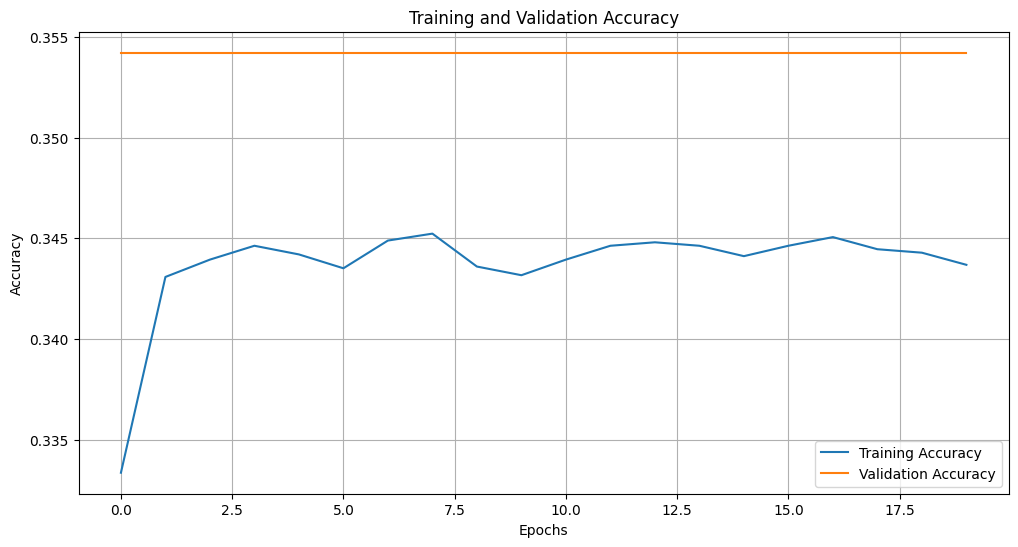

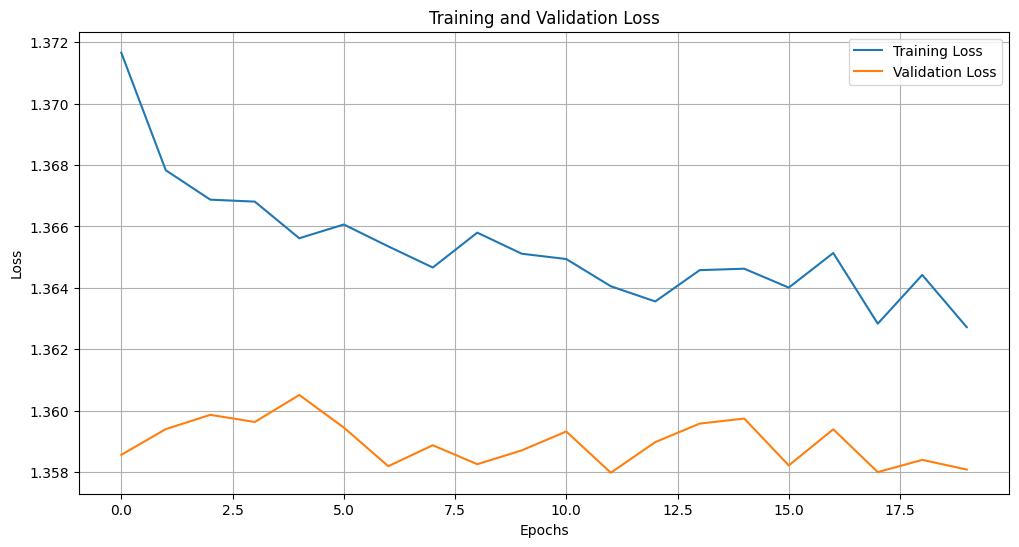

In [13]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Training and Validation Accuracy
* Training Accuracy:

The training accuracy seems to plateau at around 34.5%, which is quite low.
This suggests that the model might not be learning sufficient patterns from the training data.

* Validation Accuracy:

The validation accuracy is constant (flat line), likely around 35%, indicating the model is not improving its generalization capabilities during training.
This could mean the model is not complex enough for the task, or there is an issue with the data (e.g., noisy or insufficient data).

## Training and Validation Loss
* Training Loss:

The training loss is decreasing gradually, which is expected, indicating the model is learning to some extent.
However, the pace of reduction in training loss is very slow, reflecting limited learning capacity.
* Validation Loss:

The validation loss remains significantly lower than the training loss, which is unusual. Normally, the validation loss should be close to or slightly higher than the training loss.

## This could point to:
A possible issue with how the validation set was split or preprocessed.
The validation data might be easier for the model to predict compared to the training data.
## Interpretation
* Underfitting:

The model is underfitting the data, as indicated by the low accuracy and high training loss. It’s unable to capture the complexity of the problem, which could be due to:

1- Insufficient model complexity (e.g., the frozen base model limits learning).

2- Poor feature extraction (base layers not contributing effectively to the task).

3- Insufficient or noisy training data.
## Suggestions for Improvement:

* Unfreeze the Base Model: Allow some or all layers of EfficientNetV2M to be trainable, especially higher layers closer to the output, to learn task-specific features.
* Increase Training Time: Train the model for more epochs to allow sufficient learning.
* Hyperparameter Tuning:
Increase the learning rate initially and reduce it later (use a learning rate scheduler).
  


# 3. FINE-TUNED MODEL

## A- Attention Module


The attention module applies spatial attention to highlight important facial regions in the input tensor. A convolutional layer with a single filter and a sigmoid activation generates an attention map, which is then multiplied with the original input. This mechanism allows the model to focus on key areas of the face that are most relevant for emotion recognition, enhancing its ability to learn meaningful features.

In [11]:
def attention_module(input_tensor):
    """Apply spatial attention to focus on key facial regions."""
    attention = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(input_tensor)
    return Multiply()([input_tensor, attention])

## B- Learning Rate Scheduler


The learning rate scheduler dynamically adjusts the learning rate during training. For the first 5 epochs, the learning rate remains unchanged. Afterward, it decays exponentially by a factor to enable more precise weight updates in later stages of training, improving model convergence.

In [12]:
from tensorflow.keras import backend as K

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return K.get_value(lr * tf.math.exp(-0.2))


## C- Model with Attention and Single Classification Head

### Pretrained Base Model:

EfficientNetV2M is used as the base model, pre-trained on ImageNet, with its top layer removed (include_top=False). All layers are unfrozen (trainable=True) to enable fine-tuning for the target task.

### Attention Mechanism:

An attention module is applied to emphasize important regions in the feature maps, improving the model's focus on relevant areas.

### Feature Aggregation:

* Global Average Pooling is applied to condense spatial features into a single vector for each feature map, reducing dimensionality while retaining key information.

### Fully Connected Layers:

* Two dense layers (512 and 1024 neurons) with ReLU activation are added.
* Batch normalization layers follow each dense layer to stabilize and accelerate training.
* Dropout layers (0.4 rate) are included to prevent overfitting.
  
### Regularization:

* l2-regularizer is applied to the second dense layer to mitigate overfitting by penalizing large weights.

### Classification Head:

A final dense layer with a softmax activation outputs the predicted probabilities for each class.

### Final Model:

Combines the base model and custom layers to create a fine-tuned model tailored for the specific classification task.

In [10]:
def create_fine_tuned_model(input_shape, num_classes):
    # Pretrained EfficientNetV2M
    base_model = tf.keras.applications.EfficientNetV2M(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True  # Unfreeze all layers for fine-tuning

    # Attention Module
    x = base_model.output
    x = attention_module(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layers with BatchNorm
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
   
    # Classification Head
    classification_output = Dense(num_classes, activation='softmax', name='classification_head')(x)

    # Final Model
    model = Model(inputs=base_model.input, outputs=classification_output)
    return model

# Input Shape and Classes
input_shape = (224, 224, 3)
num_classes = len(class_names)  # Use the class_names variable you stored previously

# Create Model
model = create_fine_tuned_model(input_shape, num_classes)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## COMPILE AND TRAIN THE MODEL

### Early Stopping:

Monitors the validation accuracy (val_accuracy) to stop training if no improvement is observed for 7 consecutive epochs.Restores the best model weights from before training stagnated to ensure optimal performance.

### Learning Rate Scheduler:

Dynamically adjusts the learning rate during training using the previously defined scheduler function for better convergence.

### Model Compilation:

Compiled with the Adam optimizer (learning rate: 0.001), categorical cross-entropy loss for multi-class classification, and accuracy as the evaluation metric.

### Training Process:

* Trained for up to 55 epochs, with early stopping potentially halting training earlier to avoid overfitting.
Uses both train_dataset and val_dataset for training and validation.
* Includes lr_callback for learning rate adjustment and early_stopping for efficient training.

In [13]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=7,  # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

lr_callback = LearningRateScheduler(scheduler)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Model
EPOCHS = 55
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[lr_callback,early_stopping]
)

Epoch 1/55
364/364 ━━━━━━━━━━━━━━━━━━━━ 598s 1s/step - accuracy: 0.5722 - loss: 5.9400 - val_accuracy: 0.4757 - val_loss: 1.9917 - learning_rate: 0.0010
Epoch 2/55
364/364 ━━━━━━━━━━━━━━━━━━━━ 248s 680ms/step - accuracy: 0.7047 - loss: 1.2627 - val_accuracy: 0.3542 - val_loss: 1.7720 - learning_rate: 0.0010
Epoch 3/55
364/364 ━━━━━━━━━━━━━━━━━━━━ 248s 680ms/step - accuracy: 0.6915 - loss: 0.9787 - val_accuracy: 0.3542 - val_loss: 93.9237 - learning_rate: 0.0010
Epoch 4/55
364/364 ━━━━━━━━━━━━━━━━━━━━ 248s 682ms/step - accuracy: 0.5417 - loss: 1.2538 - val_accuracy: 0.5628 - val_loss: 0.9694 - learning_rate: 0.0010
Epoch 5/55
364/364 ━━━━━━━━━━━━━━━━━━━━ 248s 681ms/step - accuracy: 0.6071 - loss: 0.9096 - val_accuracy: 0.6282 - val_loss: 0.8410 - learning_rate: 0.0010
Epoch 6/55
364/364 ━━━━━━━━━━━━━━━━━━━━ 248s 681ms/step - accuracy: 0.6425 - loss: 0.8490 - val_accuracy: 0.6840 - val_loss: 0.7791 - learning_rate: 8.1873e-04
Epoch 7/55
364/364 ━━━━━━━━━━━━━━━━━━━━ 248s 680ms/step - accu

In [14]:
# Save the model in the HDF5 format
model.save('final_model.h5')

## PLOT TRAINING AND VALIDATION LOSS/ACCURACY

In [35]:
# Visualize Results
def plot_metrics(history, metric, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

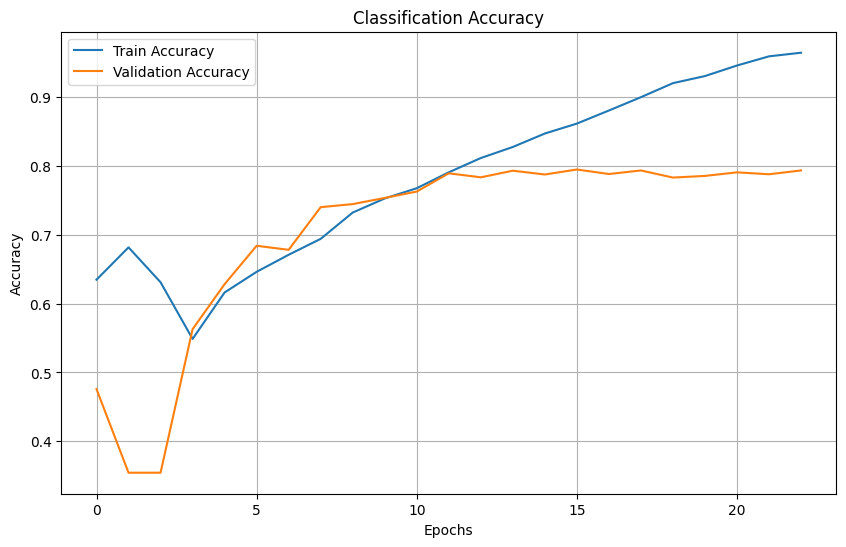

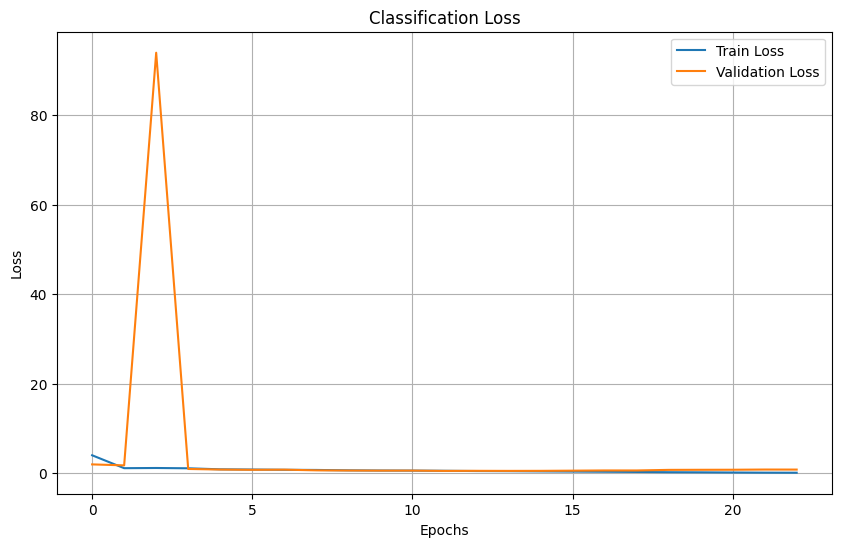

In [16]:
plot_metrics(history, 'accuracy', 'Classification Accuracy')
plot_metrics(history, 'loss', 'Classification Loss')

## Classification Accuracy:

### Training Accuracy:

The training accuracy shows a consistent upward trend over the epochs, indicating that the model is learning from the training data effectively.
However, the gap between training and validation accuracy suggests the model might be slightly overfitting as it performs better on the training data compared to the validation set.

### Validation Accuracy:

The validation accuracy improves initially, stabilizing around 0.75–0.8 after a few epochs. This plateau suggests the model has reached its learning capacity on the validation data.

## Classification Loss:

### Training Loss:

The training loss steadily decreases, indicating the model is minimizing errors on the training data effectively.
This aligns with the increase in training accuracy.

### Validation Loss:

The validation loss shows an anomaly with a sharp spike at the beginning. This could be due to instability in early epochs, potentially from a high initial learning rate or class imbalance.
After the spike, the validation loss stabilizes and aligns closely with the training loss, indicating good generalization.

# 4. FINE-TUNED MODEL WITH EARLY EXITS

## A- Add Early Exits


### Pretrained Base Model:

EfficientNetV2M is used as the backbone, pre-trained on ImageNet, with the top layer removed (include_top=False).
All layers are unfrozen (trainable=True) to enable fine-tuning.
Attention Mechanism:

* An attention module is applied to enhance focus on critical features by highlighting relevant regions in the feature maps.

### Early Exits:

#### Early Exit 1 (Shallow Layer):

* Provides an output at an intermediate layer for faster inference or scenarios requiring less computational complexity.
* Includes layers like Global Average Pooling, a dense layer with 128 neurons, batch normalization, dropout (0.3), and a softmax classifier.

#### Early Exit 2 (Mid-Level Layer):

* Another intermediate output at a deeper layer, balancing complexity and computational efficiency.
* Includes Global Average Pooling, a dense layer with 256 neurons, batch normalization, dropout (0.4), and a softmax classifier.
  
#### Final Output (Last Layer):

* Represents the complete output after deep processing in the base model.
* Layers include Global Average Pooling, fully connected layers with 512 and 1024 neurons, batch normalization, dropout (0.4), 
* l2-regularization, and a softmax classifier.

#### Multi-Output Model:

* Combines all early exits and the final output into a single model.
* Outputs predictions from multiple stages for flexibility in inference and computational trade-offs.

#### Purpose:

Early exits enable dynamic inference, allowing the model to stop processing earlier for simpler inputs, thus optimizing computational efficiency.

In [8]:
# Create Fine-Tuned Model with Multiple Early Exits
def create_fine_tuned_model_with_early_exits(input_shape, num_classes):
    # Pretrained EfficientNetV2M
    base_model = tf.keras.applications.EfficientNetV2M(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True  # Unfreeze all layers for fine-tuning

    # Attention Module
    x = base_model.output
    x = attention_module(x)

    # Early Exit 1 (Shallow Layer)
    early_exit_1 = GlobalAveragePooling2D()(x)
    early_exit_1 = Dense(128, activation='relu')(early_exit_1)
    early_exit_1 = BatchNormalization()(early_exit_1)
    early_exit_1 = Dropout(0.3)(early_exit_1)
    early_exit_1_output = Dense(num_classes, activation='softmax', name='early_exit_1_output')(early_exit_1)

    # Early Exit 2 (Mid-Level Layer)
    early_exit_2 = GlobalAveragePooling2D()(x)
    early_exit_2 = Dense(256, activation='relu')(early_exit_2)
    early_exit_2 = BatchNormalization()(early_exit_2)
    early_exit_2 = Dropout(0.4)(early_exit_2)
    early_exit_2_output = Dense(num_classes, activation='softmax', name='early_exit_2_output')(early_exit_2)

    # Final Output (Last Layer)
    x_final = GlobalAveragePooling2D()(x)
    x_final = Dense(512, activation='relu')(x_final)
    x_final = BatchNormalization()(x_final)
    x_final = Dropout(0.4)(x_final)
    x_final = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x_final)
    x_final = BatchNormalization()(x_final)
    x_final = Dropout(0.4)(x_final)
    final_output = Dense(num_classes, activation='softmax', name='final_output')(x_final)

    # Create Multi-Output Model
    model = Model(inputs=base_model.input, outputs=[early_exit_1_output, early_exit_2_output, final_output])
    return model

The **preprocess_data** function normalizes input images by scaling pixel values to the range [0, 1], ensuring consistency for model training. Additionally, it formats the labels as a dictionary to align with the multi-output structure of the model, providing the same label for each of the early exits and the final output. This ensures the data is properly structured for training a multi-output model.

In [23]:
def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    
    # Ensure labels are formatted as a dictionary for multi-output
    label = {
        'early_exit_1_output': label,
        'early_exit_2_output': label,
        'final_output': label
    }
    return image, label

In [24]:
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Create Model with Early Exits


### Model Creation:

The fine-tuned model with multiple early exits is created using the create_fine_tuned_model_with_early_exits function, incorporating early exit layers and a final output layer.

### Early Stopping Callback:

* Monitors the validation accuracy of the final output (val_final_output_accuracy).
* Stops training if there is no improvement after 7 consecutive epochs.
* Restores the best model weights from the training process.

### Model Compilation:

* Optimizer: Adam optimizer with a learning rate of 0.001 is used for efficient gradient updates.
* Loss Function: Categorical cross-entropy loss is assigned to each output (early_exit_1_output, early_exit_2_output, and final_output) to handle multi-class classification.
* Metrics: Accuracy is tracked individually for all outputs to evaluate performance at each exit.

### Model Training:

* The model is trained for a maximum of 25 epochs using the training and validation datasets.
* Includes a learning rate callback (lr_callback) to adjust the learning rate dynamically during training.
* Training leverages the multi-output structure, allowing evaluation at multiple levels of the network.

In [33]:
model = create_fine_tuned_model_with_early_exits(input_shape, num_classes)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_final_output_accuracy',  # Monitor final output validation accuracy
    patience=7,  # Stop after 7 epochs of no improvement
    restore_best_weights=True  # Restore the best model weights
)

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'early_exit_1_output': 'categorical_crossentropy',
        'early_exit_2_output': 'categorical_crossentropy',
        'final_output': 'categorical_crossentropy'
    },
    metrics={
        'early_exit_1_output': 'accuracy',
        'early_exit_2_output': 'accuracy',
        'final_output': 'accuracy'
    }
)

# Train the Model
EPOCHS = 25
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[lr_callback]
)

Epoch 1/25
364/364 ━━━━━━━━━━━━━━━━━━━━ 553s 965ms/step - early_exit_1_output_accuracy: 0.3109 - early_exit_1_output_loss: 1.5223 - early_exit_2_output_accuracy: 0.2973 - early_exit_2_output_loss: 1.6403 - final_output_accuracy: 0.2749 - final_output_loss: 1.9327 - loss: 9.8395 - val_early_exit_1_output_accuracy: 0.3542 - val_early_exit_1_output_loss: 1.3618 - val_early_exit_2_output_accuracy: 0.3542 - val_early_exit_2_output_loss: 1.3623 - val_final_output_accuracy: 0.3542 - val_final_output_loss: 1.3761 - val_loss: 5.2905 - learning_rate: 0.0010
Epoch 2/25
364/364 ━━━━━━━━━━━━━━━━━━━━ 231s 634ms/step - early_exit_1_output_accuracy: 0.3293 - early_exit_1_output_loss: 1.4470 - early_exit_2_output_accuracy: 0.3272 - early_exit_2_output_loss: 1.4785 - final_output_accuracy: 0.2927 - final_output_loss: 1.6346 - loss: 5.4530 - val_early_exit_1_output_accuracy: 0.3542 - val_early_exit_1_output_loss: 2.5641 - val_early_exit_2_output_accuracy: 0.3542 - val_early_exit_2_output_loss: 5.9897 - v

## PLOT TRAINING AND VALIDATION LOSS/ACCURACY FOR ALL OUTPUTS

In [37]:
def plot_metrics(history, metric, output_name, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[f'{output_name}_{metric}'], label=f'Train {metric.capitalize()}')
    plt.plot(history.history[f'val_{output_name}_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()


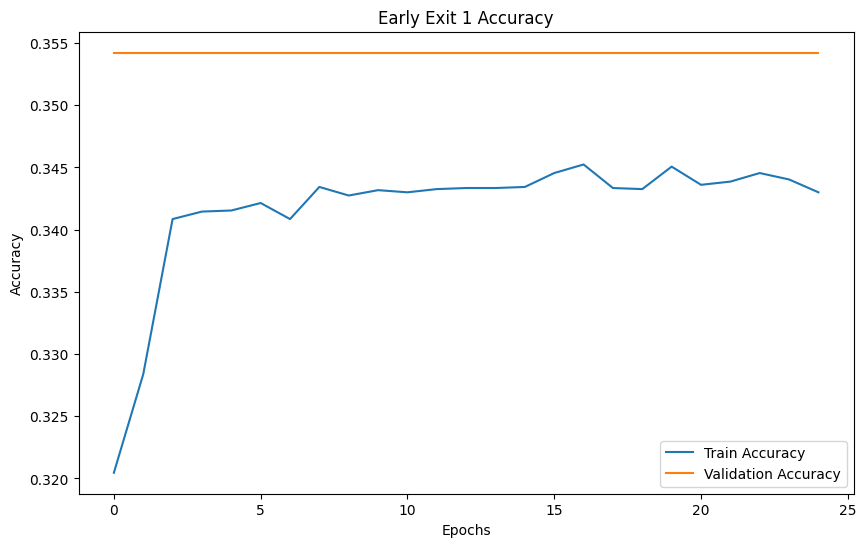

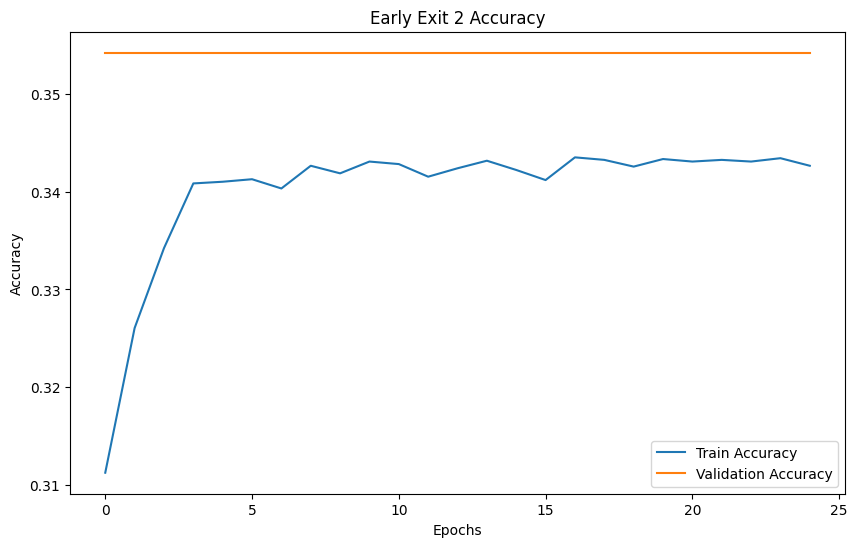

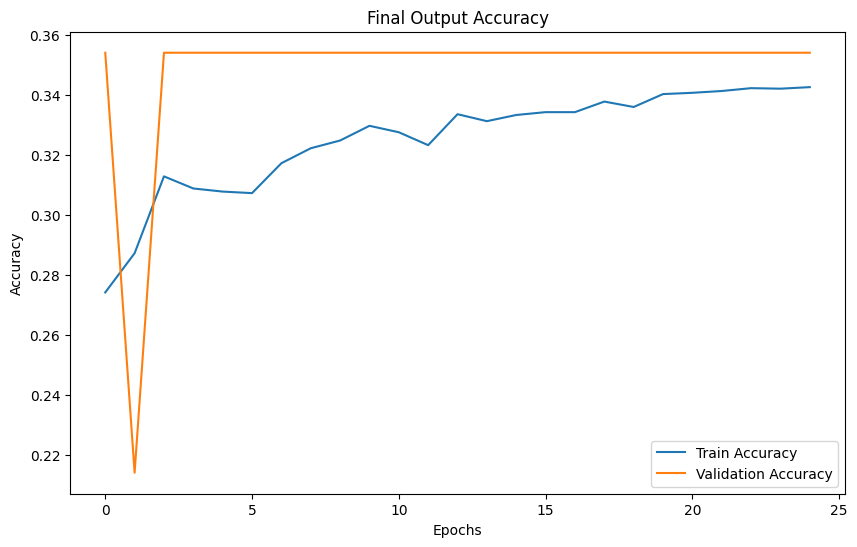

In [39]:
# Plot metrics for all outputs
plot_metrics(history, 'accuracy', 'early_exit_1_output', 'Early Exit 1 Accuracy')
plot_metrics(history, 'accuracy', 'early_exit_2_output', 'Early Exit 2 Accuracy')
plot_metrics(history, 'accuracy', 'final_output', 'Final Output Accuracy')


## Early Exit 1 Accuracy :
### Training Accuracy:

The training accuracy shows a gradual increase but plateaus around 0.34–0.35.
The model appears to have limited learning capacity at this shallow layer.
### Validation Accuracy:

Validation accuracy remains constant at approximately 0.355 throughout all epochs.
This indicates that the early exit at this level is not improving its performance over training epochs, possibly due to insufficient complexity in features at this layer.
## Early Exit 2 Accuracy :
### Training Accuracy:

Training accuracy increases steadily and stabilizes around 0.34–0.35, similar to the first exit.
This indicates slightly better learning at the mid-level layer compared to the shallow one, but the improvement is marginal.
### Validation Accuracy:

Validation accuracy remains constant at approximately 0.355, similar to Early Exit 1.
The performance might be constrained by the complexity of the features extracted at this layer.
## Final Output Accuracy :
### Training Accuracy:

Training accuracy starts lower but increases more significantly than the early exits, reaching a plateau around 0.34 by the end of training.
This shows the model benefits from deeper layers for feature extraction and learning.
### Validation Accuracy:

Validation accuracy starts with a sharp spike, reaching approximately 0.355 early on and staying constant throughout the training process.
The spike could indicate instability in the initial learning phase, possibly due to a high learning rate or noisy data.


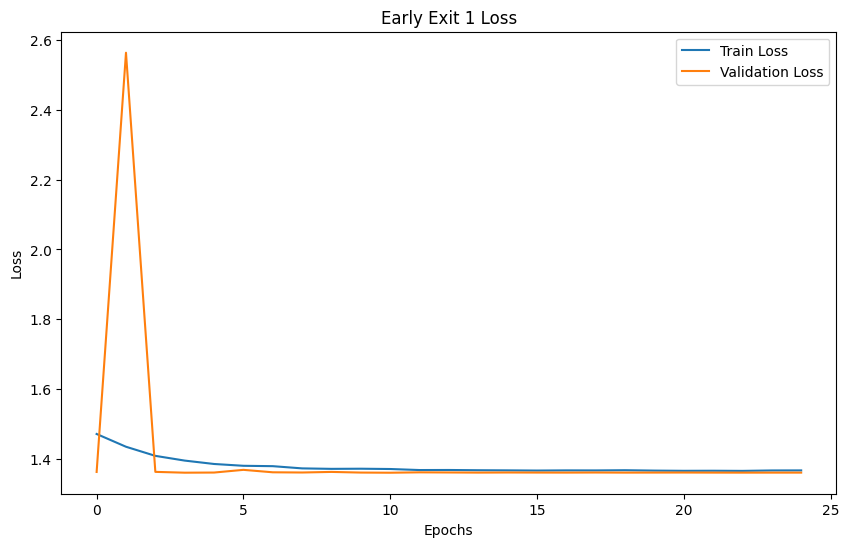

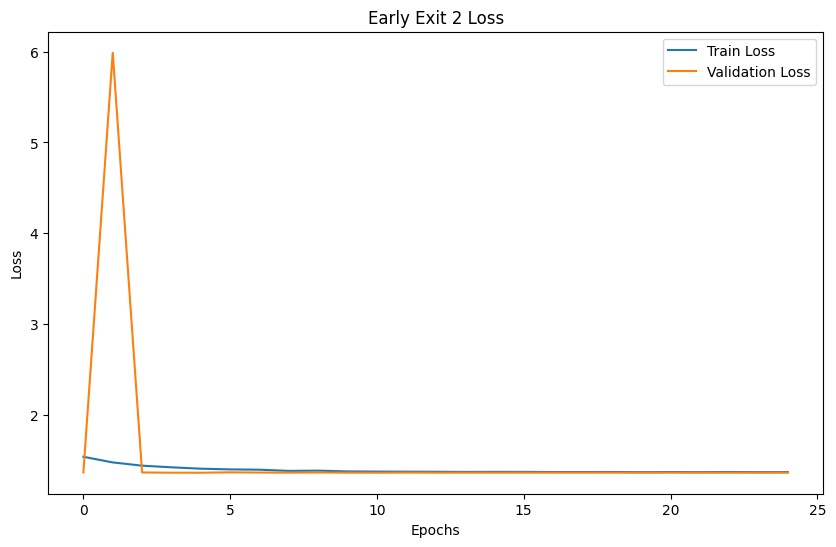

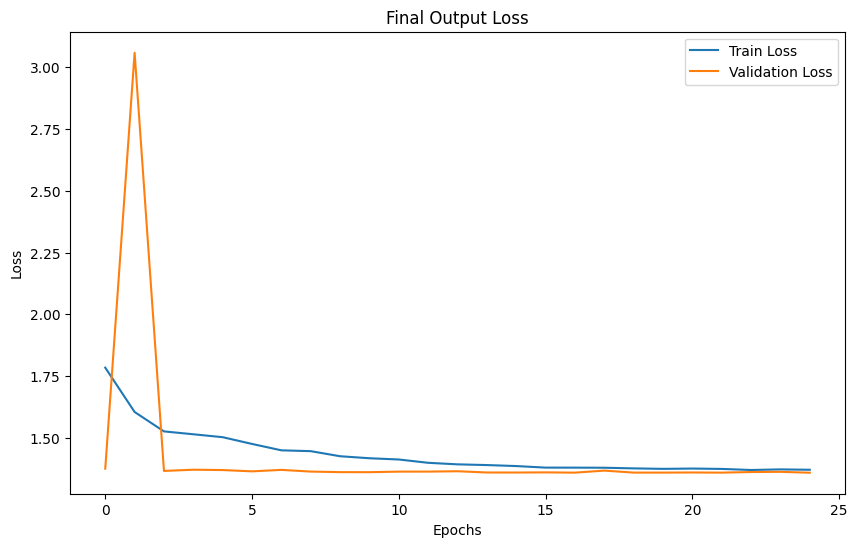

In [40]:
# Plot loss for all outputs
plot_metrics(history, 'loss', 'early_exit_1_output', 'Early Exit 1 Loss')
plot_metrics(history, 'loss', 'early_exit_2_output', 'Early Exit 2 Loss')
plot_metrics(history, 'loss', 'final_output', 'Final Output Loss')


## Early Exit 1 Loss :
### Training Loss:

The training loss decreases steadily over the epochs, indicating that the model is effectively learning from the training data.
It stabilizes at a low value after around 5 epochs, suggesting good convergence for the shallow layer.
### Validation Loss:

The validation loss shows a sharp spike at the beginning but rapidly drops and aligns closely with the training loss.
This indicates that the model is generalizing well after overcoming early instability.
## Early Exit 2 Loss :
### Training Loss:

Similar to Early Exit 1, the training loss decreases steadily and stabilizes after a few epochs.
The trend shows effective learning at this mid-layer.
### Validation Loss:

The validation loss experiences a significant spike at the beginning, likely due to instability in the early training phases.
Afterward, it quickly aligns with the training loss, suggesting improved generalization at the mid-layer.
## Final Output Loss :
### Training Loss:

The training loss decreases steadily over the epochs, similar to the earlier exits, indicating effective learning.
Stabilization occurs after about 10 epochs, reflecting good convergence at the deeper layers.
### Validation Loss:

The validation loss starts with a noticeable spike, which might result from an initial high learning rate or noisy data.
After the spike, it drops significantly and aligns closely with the training loss, showing good generalization at the final output level.